# EDA for Braintumor Segmentation

In [222]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import nibabel as nib
from IPython.display import display

In [186]:
# Import clinical Data Files

df_clin = pd.read_csv('data/further_infos/UPENN-GBM_clinical_info_v1.0.csv')

In [187]:
# Import Data Files of Acquisition
df_acqui = pd.read_csv('data/further_infos/UPENN-GBM_acquisition.csv')

In [188]:
# Import Data File Availability
df_avai = pd.read_csv('data/further_infos/UPENN-GBM_data_availability.csv')

## Create a working list 

containing age, gender, tumour-type, ...
named df

In [207]:
# merge all infos
brain_seg_all = pd.merge(df_acqui,df_clin, on='ID', how='inner')

In [208]:
# replace gender: male is 0, female is 1
brain_seg_all.Gender.replace('M',0,inplace=True)
brain_seg_all.Gender.replace('F',1,inplace=True)

In [190]:
# create new column for gender as integer
#brain_seg_all['male'] = np.where(brain_seg_all['Gender'] == 'M', 1, 0)

In [209]:
# drop unneeded columns
brain_seg_incl_seq = brain_seg_all.drop(['Manufacturer', 'Model', 'DTI Imaging Frequency', 'DTI Repetition Time', 'DTI Echo Time', 'DTI Flip Angle', 'DTI Pixel Spacing', 'DTI Slice Thickness', 'DSC Imaging Frequency', 'DSC Repetition Time', 'DSC Echo Time', 'DSC Flip Angle', 'DSC Pixel Spacing', 'DSC Slice Thickness'], axis=1)

In [210]:
# keep only preop datasets, list contains all used sequences
preop_allseq = brain_seg_incl_seq.drop(brain_seg_incl_seq[brain_seg_incl_seq['ID'].str.endswith('_21')].index)

In [211]:
# drop unneeded sequence infos
preop_small_df = preop_allseq.drop(['T1 Imaging Frequency',
       'T1 Repetition Time', 'T1 Echo Time', 'T1 Inversion Time',
       'T1 Flip Angle', 'T1 Pixel Spacing', 'T1 Slice Thickness',
       'T1GD Imaging Frequency', 'T1GD Repetition Time', 'T1GD Echo Time',
       'T1GD Inversion Time', 'T1GD Flip Angle', 'T1GD Pixel Spacing',
       'T1GD Slice Thickness', 'T2 Imaging Frequency', 'T2 Repetition Time',
       'T2 Echo Time', 'T2 Flip Angle', 'T2 Pixel Spacing',
       'T2 Slice Thickness', 'FLAIR Imaging Frequency',
       'FLAIR Repetition Time', 'FLAIR Echo Time', 'FLAIR Inversion Time',
       'FLAIR Flip Angle', 'FLAIR Pixel Spacing', 'FLAIR Slice Thickness'], axis=1)


In [212]:
preop_small_df.head()

,ID,Magnetic Field Strength,Gender,Age_at_scan_years,Survival_from_surgery_days,IDH1,MGMT,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
0,UPENN-GBM-00001_11,3.0,1,52.16,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
1,UPENN-GBM-00002_11,3.0,1,61.30,291,Wildtype,Not Available,Not Available,Y,0,NaN
2,UPENN-GBM-00003_11,3.0,0,42.82,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
3,UPENN-GBM-00004_11,3.0,0,33.43,Not Available,NOS/NEC,Not Available,Not Available,Y,0,NaN
4,UPENN-GBM-00005_11,3.0,0,53.33,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN


#### Checking the Data

In [214]:
print (preop_small_df['Gender'].value_counts())
print (preop_small_df['Magnetic Field Strength'].value_counts())
print (preop_small_df['IDH1'].value_counts())
print (preop_small_df['Age_at_scan_years'].mean())

0    367
1    244
Name: Gender, dtype: int64
3.00000    537
1.50000     73
2.89362      1
Name: Magnetic Field Strength, dtype: int64
Wildtype    499
NOS/NEC      96
Mutated      16
Name: IDH1, dtype: int64
62.97759410801964


In [223]:
display (preop_small_df['Gender'].value_counts())
display (preop_small_df['Magnetic Field Strength'].value_counts())
display (preop_small_df['IDH1'].value_counts())
display (preop_small_df['Age_at_scan_years'].mean())

0    367
1    244
Name: Gender, dtype: int64

3.00000    537
1.50000     73
2.89362      1
Name: Magnetic Field Strength, dtype: int64

Wildtype    499
NOS/NEC      96
Mutated      16
Name: IDH1, dtype: int64

62.97759410801964

In [216]:
# create column groups of age
def categorise(row):
    if row['Age_at_scan_years'] < 40: 
        return '<40'
    elif row['Age_at_scan_years'] >= 40 and row['Age_at_scan_years'] < 50 : 
        return '40-50'
    elif row['Age_at_scan_years'] >= 50 and row['Age_at_scan_years'] < 60 : 
        return '50-60'
    elif row['Age_at_scan_years'] >= 60 and row['Age_at_scan_years'] < 70 : 
        return '60-70'
    elif row['Age_at_scan_years'] >= 70 and row['Age_at_scan_years'] < 80 : 
        return '70-80'
    return '>80'



preop_small_df['age_group'] = preop_small_df.apply(lambda row: categorise(row), axis=1)


In [217]:
preop_small_df.isnull().sum()*100/len(preop_small_df)

ID                              0.0
Magnetic Field Strength         0.0
Gender                          0.0
Age_at_scan_years               0.0
Survival_from_surgery_days      0.0
IDH1                            0.0
MGMT                            0.0
KPS                             0.0
GTR_over90percent               0.0
Time_since_baseline_preop       0.0
PsP_TP_score                  100.0
age_group                       0.0
dtype: float64

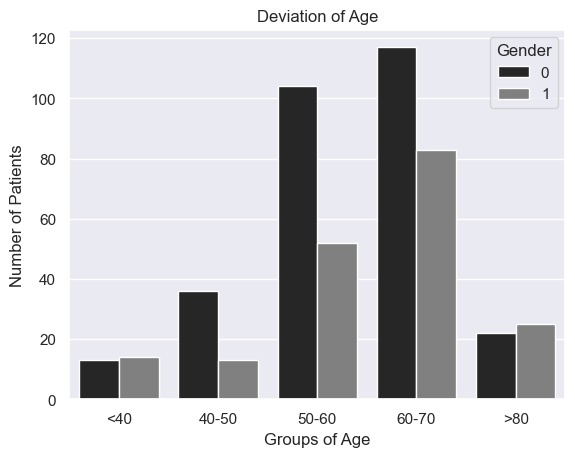

In [218]:
# barchart
sns.countplot(x=preop_small_df['age_group'], hue=preop_small_df.Gender, palette='dark:grey',
    order=['<40','40-50','50-60','60-70','>80'])

# Labeling
plt.ylabel("Number of Patients")
plt.xlabel("Groups of Age")
plt.title("Deviation of Age")

plt.show()

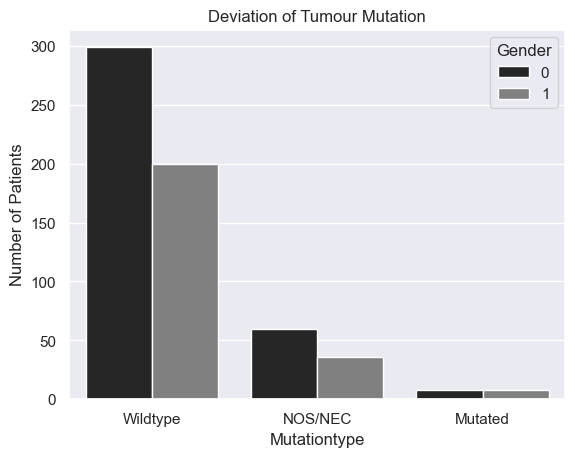

In [219]:
# barchart
sns.countplot(x=preop_small_df['IDH1'], hue=preop_small_df.Gender, palette='dark:grey')

# Labeling
plt.ylabel("Number of Patients")
plt.xlabel("Mutationtype")
plt.title("Deviation of Tumour Mutation")

plt.show()